# Laboratory 6 homework

Homework is applying all techniques learned during the lab on the [Banking77
dataset](https://huggingface.co/datasets/PolyAI/banking77). It consists of
online banking queries, annotated with their corresponding intents, resulting in
77 classes. It's already split into training and testing parts, with F1 score
typically used for evaluation. It is also [known to have label
errors](https://aclanthology.org/2022.insights-1.19/), great for data-centric AI
approach. Label descriptions are [available
here](https://huggingface.co/datasets/PolyAI/banking77#data-fields).

1. Download and load the data. Perform the initial exploration and cleaning.
   - it is already split into training and testing parts
   - labels go from 0 to 76
   - checks should include e.g.:
     - checking data types, number of texts,
     - plotting the class distribution
     - plotting the histogram of text lengths

In [46]:
import os

# Yeah, these warnings are pretty annoying
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [47]:
import pandas as pd
from datasets import load_dataset

df: pd.DataFrame = load_dataset("PolyAI/banking77")["train"].to_pandas()  # type: ignore

In [48]:
print("Data types:")
display(df.dtypes)

Data types:


text     object
label     int64
dtype: object

In [49]:
print("Total data length:", len(df))

Total data length: 10003


In [50]:
df.sample(10)

,text,label
7145,How can I transfer money to a beneficiary?,7
834,How is my ATM deposit not available yet?,46
3585,There is a vendor name I don't recognize on a ...,16
4497,My statement shows charges for things I never ...,22
7046,"Hi, I am interested buying crypto currency but...",7
8588,My topping up didn't go through.,59
377,How do you decide what your exchange rates are?,32
1453,I would like to exchange currency What types ...,33
1399,Is exchanging currencies one of your app servi...,33
4066,I havn't received my PIN yet.,38


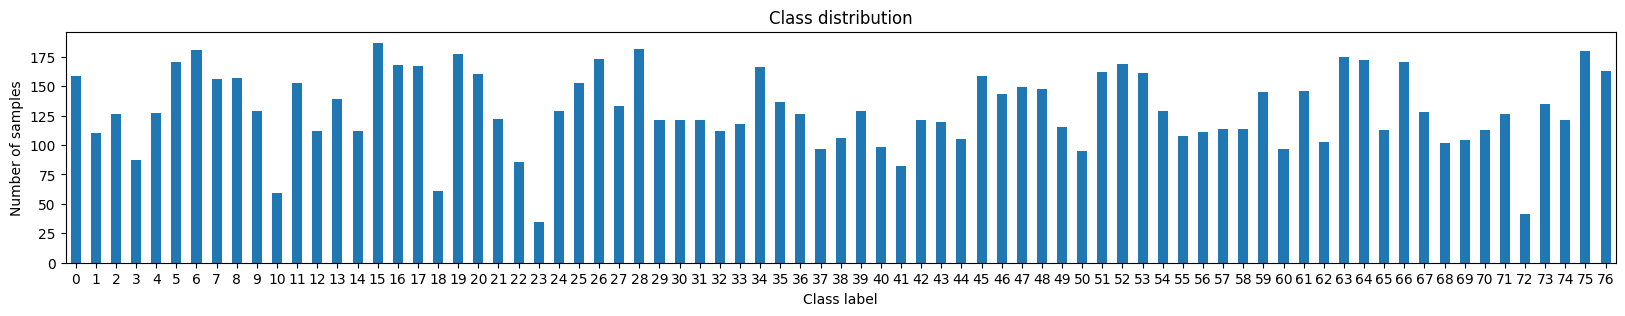

In [51]:
(
    df["label"]
    .value_counts()
    .sort_index()
    .plot.bar(
        figsize=(20, 3),
        ylabel="Number of samples",
        xlabel="Class label",
        title="Class distribution",
        rot=0,
    )
);

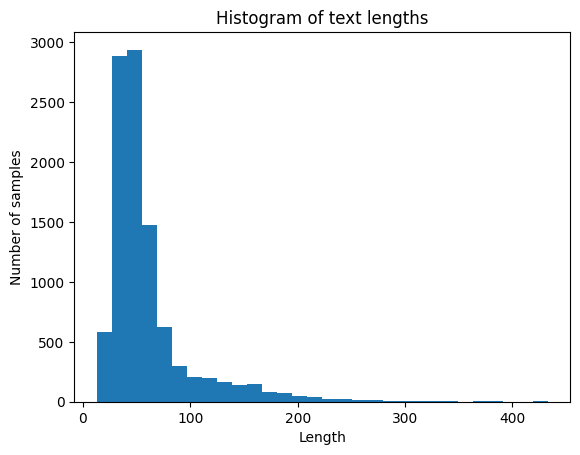

In [52]:
(
    df["text"]
    .str.len()
    .plot.hist(
        bins=30,
        title="Histogram of text lengths",
        xlabel="Length",
        ylabel="Number of samples",
    )
);

In [53]:
df["text"] = df["text"].str.strip()
df = df[df["text"].str.len() > 0].reset_index(drop=True)
df.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


2. Use CleanLab to detect and fix data quality issues:
   - use `all-MiniLM-L6-v2` Sentence Transformer embeddings + logistic
     regression as the model
   - note that `LogisticRegressionCV` works out-of-the-box for multiclass
     classification, and you should use `class_weight="balanced"` in case of
     class imbalance
   - detect and fix: label issues, near duplicates, outliers
   - when analyzing duplicates, you can print rows at given indices with
     `.iloc[]`
   - comment:
     - do your results agree with [the
       paper](https://aclanthology.org/2022.insights-1.19/) pointing out the
       label quality issues?
     - are the problems severe and worth fixing in your opinion?

In [54]:
from numpy.typing import NDArray
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(texts: NDArray, labels: NDArray) -> tuple[NDArray, NDArray]:
    embeddings = SentenceTransformer("all-MiniLM-L6-v2").encode(texts)

    clf = LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=0)
    pred_probs = cross_val_predict(clf, embeddings, labels, cv=5, method="predict_proba", n_jobs=-1)

    return embeddings, pred_probs

In [55]:
texts: NDArray = df["text"].values  # type: ignore
labels: NDArray = df["label"].values  # type: ignore
embeddings, pred_probs = get_initial_model_data(texts, labels)

In [56]:
from cleanlab import Datalab

data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 632 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         150
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

**Label issues**

In [57]:
label_mapping = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "Refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment?",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal",
}

In [58]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true: {label_mapping[y_true]:>40s} | y_pred: {label_mapping[y_pred]:>30s} | text: {text}")

Top 10 label issues
y_true:                             card_arrival | y_pred:               card_not_working | text: WHAT IS THE SOLUTION OF THIS PROBLEM
y_true:                   disposable_card_limits | y_pred:           getting_virtual_card | text: i am not a premium customer but i want a virtual card, how do i get it
y_true:                      lost_or_stolen_card | y_pred:                   card_arrival | text: Can you tell me the status of my new card?
y_true:                        declined_transfer | y_pred:        beneficiary_not_allowed | text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account
y_true:                         card_not_working | y_pred:                    pin_blocked | text: Can I use app to reset PIN attempts?
y_true:                              pin_blocked | y_pred:              get_physical_card | text: Where do I find PIN for my card?
y_true:                           pending_top_up | y_pred:             toppi

There are definietly some problems with labels and while some are more obvious
than others (e.g. the last example where the predicted label fits much better)
the main problem IMO is that the labels themselves are too vague or broad (and
not orthogonal to each other) and the given text could just as well be labeled
with few different labels. Since there are only 150 rows that CleanLab marked as
potential label issues we can just as well fix them although IMO it won't solve
the main problem mentioned above.

In [59]:
idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_fixed_labels = df.copy()
df_fixed_labels.loc[idxs, "label"] = pred_labels
df_fixed_labels

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


**Near duplicates**

In [60]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

In [61]:
duplicate_issues

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
1710,True,0.000000,[1724],0.000000
4594,True,0.000000,[4595],0.000000
4595,True,0.000000,[4594],0.000000
4903,True,0.000000,"[4915, 4839]",0.000000
4915,True,0.000000,"[4903, 4839]",0.000000
...,...,...,...,...
4403,True,0.121104,[4437],0.011252
4437,True,0.121104,[4403],0.011252
2309,True,0.121141,[2237],0.011256
2237,True,0.121141,[2309],0.011256


In [62]:
for idx, row in duplicate_issues.head(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text     : {repr(text)}")
    print(f"Duplicates: {[repr(txt) for txt in neighbors]}")
    print()

Text     : 'I put the wrong pin too many times and now it is blocked. Can you help me unblock it?'
Duplicates: ["'I put the wrong pin too many times and now it is blocked. Can you help me unblock it?'"]

Text     : 'Where can I withdraw money from?'
Duplicates: ["'Where can I withdraw money from?'"]

Text     : 'Where can I withdraw money from?'
Duplicates: ["'Where can I withdraw money from?'"]

Text     : 'How can I reset my passcode?'
Duplicates: ["'How can i reset my passcode ?'", "'How do I reset my passcode?'"]

Text     : 'How can i reset my passcode ?'
Duplicates: ["'How can I reset my passcode?'", "'How do I reset my passcode?'"]

Text     : 'I put the wrong pin too many times and now it is blocked. Can you help me unblock it?'
Duplicates: ["'I put the wrong pin too many times and now it is blocked. Can you help me unblock it?'"]

Text     : 'Why do you keep declining my payment? I tried several times already with this card and it is just not working.'
Duplicates: ["'Why do yo

In [63]:
for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text      : {repr(text)}")
    print(f"Duplicates: {[repr(txt) for txt in neighbors]}")
    print()

Text      : "What should I do if I can't prove my identity."
Duplicates: ['"What do I do if I can\'t prove my identity?"']

Text      : 'How can I receive a virtual card?'
Duplicates: ["'How do I receive a virtual card?'"]

Text      : 'How do I receive a virtual card?'
Duplicates: ["'How can I receive a virtual card?'"]

Text      : 'Can you please tell me why my transfer failed?'
Duplicates: ["'Can you please explain why my transfer failed?'"]

Text      : 'Can you please explain why my transfer failed?'
Duplicates: ["'Can you please tell me why my transfer failed?'"]

Text      : 'Is there a limit to a disposable virtual card?'
Duplicates: ["'Is there a limit to using a disposable virtual card?'"]

Text      : 'Is there a limit to using a disposable virtual card?'
Duplicates: ["'Is there a limit to a disposable virtual card?'"]

Text      : 'Can I top up any amount?'
Duplicates: ["'Can I top-up any amount?'"]

Text      : 'Can I top-up any amount?'
Duplicates: ["'Can I top up any am

It seems that the duplicates are mostly almost the same (they differ by spelling
or formatting) and we should probably delete them.

In [64]:
from cleanlab_utils import filter_near_duplicates

ids_to_remove = filter_near_duplicates(duplicate_issues)
df_deduplicated = df_fixed_labels.drop(duplicate_issues[ids_to_remove].index)
df_deduplicated

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


**Outliers**

In [65]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score")

texts_outliers = texts[outlier_issues.head(10).index]

for text in texts_outliers:
    print(f"Outlier text: {text}")
    print()

Outlier text: WHAT IS THE ATMOSPHERE OF IT

Outlier text: what is the word?

Outlier text: What is this witdrawal

Outlier text: what is the matter?

Outlier text: WHAT IS THE SOLUTION OF THIS PROBLEM

Outlier text: I prefer Mastecard.

Outlier text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?

Outlier text: WHAT IS THE MAIN REASON OF THIS PROBLEM

Outlier text: WHAT IS THE REASON FOR THAT

Outlier text: why was i chargged



The outliers are pretty much what we would expect. They don't have a
well-defined labels and as such lower the quality of our data - we will remove
them.

In [66]:
outlier_issues = outlier_issues[outlier_issues.index.isin(df_deduplicated.index)]
df_removed_outliers = df_deduplicated.drop(outlier_issues.index)
df_removed_outliers

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9997,I just moved to the US how do I get a card?,24
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24


In [67]:
df_clean = df_removed_outliers.reset_index(drop=True)
df_clean

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9678,I just moved to the US how do I get a card?,24
9679,You provide support in what countries?,24
9680,What countries are you supporting?,24
9681,What countries are getting support?,24


3. Train a small text classifier:
   - you can use `distilbert/distilbert-base-uncased` model, or any other that
     you want
   - make 80-20% train-valid split
   - use F1-score to select the best model
   - perform hyperparameter tuning, or use larger learning rate and train for
     longer than in the lab, since the dataset is small and task is harder
   - modify how `y_pred_proba` and `y_pred` are returned to accommodate
     multiclass classification, `np.argmax()` may be useful

In [68]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_clean, train_size=0.8, random_state=0, stratify=df_clean["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")  # type: ignore
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")  # type: ignore
datasets_dict["test"] = load_dataset("PolyAI/banking77", split="test")  # type: ignore

In [69]:
import torch
from transformers.models.auto.tokenization_auto import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1937 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [70]:
import os
import random
import numpy as np

# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [71]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from torch.nn.functional import softmax

from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification
from transformers.training_args import TrainingArguments
from transformers.trainer_utils import EvalPrediction
from transformers.trainer import Trainer


model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()  # type: ignore
    y_pred = eval_pred.predictions.argmax(axis=1).astype(int)  # type: ignore
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred_proba = softmax(logits, dim=1).numpy()
    return {
        "f1_score": f1_score(y_true, y_pred, average="macro"),
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "auroc": roc_auc_score(y_true, y_pred_proba, multi_class="ovo"),
    }


training_args = TrainingArguments(
    output_dir="finetuned_model",
    learning_rate=5e-5,
    num_train_epochs=5,
    metric_for_best_model="f1_score",
    eval_strategy="steps",
    save_steps=500,
    eval_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,
    dataloader_num_workers=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,  # type: ignore
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1 Score,Accuracy,Precision,Recall,Auroc
500,2.830500,1.343017,0.646825,0.703665,0.716113,0.672047,0.993638
1000,0.933000,0.531707,0.842726,0.868353,0.862406,0.846976,0.997763
1500,0.366100,0.359125,0.884699,0.897780,0.896811,0.884841,0.998820
2000,0.261400,0.284016,0.927005,0.927207,0.933590,0.924826,0.999100
2500,0.123600,0.294988,0.929263,0.927207,0.936362,0.927630,0.999061
3000,0.112600,0.272947,0.940127,0.941662,0.945461,0.938560,0.999079
3500,0.049800,0.273512,0.941514,0.940630,0.946915,0.939651,0.999264
4000,0.046400,0.283281,0.939758,0.939081,0.944025,0.938278,0.999264
4500,0.021600,0.285577,0.940732,0.940630,0.945650,0.939107,0.999235


TrainOutput(global_step=4845, training_loss=0.49128939596123, metrics={'train_runtime': 2500.4499, 'train_samples_per_second': 15.489, 'train_steps_per_second': 1.938, 'total_flos': 960785080966536.0, 'train_loss': 0.49128939596123, 'epoch': 5.0})

4. Test the resulting model:
   - check a few quality metrics
   - for multiclass metrics, use `average="macro"` (non-AUROC) or
     `multi_class="ovo"` (AUROC)
   - plot the F1-score for each class
   - comment:
     - is the overall F1-score comparable with the papers?
     - is it high enough from your perspective?
     - are there significant differences between classes?

In [72]:
pred_output = trainer.predict(datasets_tokenized["test"])  # type: ignore
logits = torch.from_numpy(pred_output.predictions)
y_pred_proba = softmax(logits, dim=1).numpy()
y_pred = logits.argmax(dim=1).numpy().astype(int)
y_test = datasets_tokenized["test"]["label"]

print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall    (macro): {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score  (macro): {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC     (ovo)  : {roc_auc_score(y_test, y_pred_proba, multi_class='ovo'):.2%}")

Precision (macro): 92.69%
Recall    (macro): 92.31%
F1-score  (macro): 92.32%
AUROC     (ovo)  : 99.84%


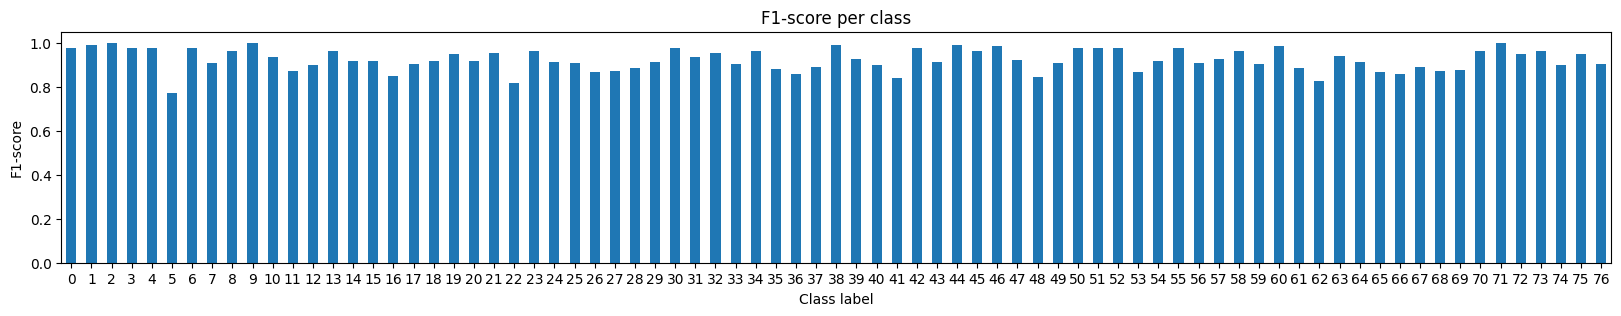

In [74]:
pd.Series(f1_score(y_test, y_pred, average=None)).plot.bar(
    figsize=(20, 3),
    ylabel="F1-score",
    xlabel="Class label",
    title="F1-score per class",
    rot=0,
);

The overall macro-averaged F1-score is almost the same as the one reported in
Table 5. in the linked [paper](https://aclanthology.org/2022.insights-1.19/)
where the authors got F1-score of 0.920 after fixing the label errors, while we
have obtained even a slightly higher value of 0.9232. Given that our dataset is
pretty small - only around 100 examples per class in the training set - the
obtained value is absolutely satisfactory.

The per-class F1-scores are mostly similiar, although there are some classes
with visibly lower score. Interestingly the lower scores are not connected to
the class imbalance.

5. Use Giskard for behavioral testing:
   - modify `prediction_function()` appropriately
   - HuggingFace pipeline has `top_k=None` option to get scores for all labels,
     not just the label with the highest probability
   - analyze the results, are there any additional problems with the resulting
     classifier?

In [ ]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan
from transformers.pipelines import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model,  # type: ignore
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
    top_k=None,
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> NDArray:
    pred_output = model_pipeline(df["text"].tolist())
    y_pred_proba = [[pred_class["score"] for pred_class in preds] for preds in pred_output]  # type: ignore
    return np.array(y_pred_proba)


df_test = load_dataset("PolyAI/banking77", split="test").to_pandas()  # type: ignore
giskard_dataset = GiskardDataset(df_test, target="label")  # type: ignore

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=range(77),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)

In [87]:
display(scan_results)

<iframe id="scan-123513832687632" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

6. Use Captum for local explainability:
   - modify the `explain_text` function from the lab to accommodate multiclass
     classification
   - explain predictions for a few samples from a test set
   - comment, is the model focusing on the right parts of texts?

In [117]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(model_copy, "distilbert.embeddings")
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(tokenizer_output["input_ids"])

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=y_true,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred = logits.argmax(dim=1).item()
        y_pred_proba = softmax(logits, dim=1)[0, y_pred].item()

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=y_true,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

In [118]:
explain_text(model, datasets_tokenized["test"]["text"][1], datasets_tokenized["test"]["label"][1])
explain_text(model, datasets_tokenized["test"]["text"][300], datasets_tokenized["test"]["label"][300])
explain_text(model, datasets_tokenized["test"]["text"][1000], datasets_tokenized["test"]["label"][1000])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
11,11 (1.00),11,0.76,"i still have not received my new card , i ordered over a week ago ."


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
12,12 (1.00),12,1.11,how fast can you deliver ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
61,61 (1.00),61,0.72,my top - up was cancelled ; will i receive a ref ##und ?


In [119]:
label_mapping[11], label_mapping[12], label_mapping[61]

('card_arrival', 'card_delivery_estimate', 'top_up_reverted')

For the examples above, model seems to pay attention to the right parts of text.